# LiberTEM-Holo : Stacking and Averaging
This code below provides an example for stacking and averaging. RigidRegstration package is used for stacking and averaging.

### Getting Started
These first few cells below are preparatory: importing the necessary python libraries and function, loading and preparing the input data.
In this example the input data is formatted as .dm4.

In [57]:
#Import necessary Libaries and Function
%matplotlib nbagg 
import numpy as np
from ncempy.io.dm import fileDM  #package to load DM file
import matplotlib.pyplot as plt 
from skimage.restoration import unwrap_phase
from scipy.signal import fftconvolve
from skimage.filters import window
import empyre as emp
import hyperspy.api as hs
from libertem_holo.base.registration import stackregistration
from time import time

#LiberTem-Holo Package
from libertem_holo.base.reconstr import (reconstruct_frame,
                                         get_slice_fft,
                                         estimate_sideband_position,
                                         estimate_sideband_size)
from libertem_holo.base.mask import disk_aperture, line_filter
from libertem_holo.base.filters import clipped, window_filter

In [14]:
#Loading data from DM4 file
with fileDM ('/cachedata/users/gunawan/04_alpha+0_obj.dm4') as f:
    data = f.getDataset(0)
with fileDM ('/cachedata/users/gunawan/05_alpha+0_ref.dm4') as f:
    data_ref = f.getDataset(0)
    
image_original = data['data'] #the input data contain one stack of Images
image_reference = data_ref['data'] #image reference for better reconstruction
number_of_images = len(image_original) #how many images in the stack

It is recomended to see the original input data before reconstruction to have a better understanding the effect of the reconstruction with the package. To show the images , hyperspy package is used.

<IPython.core.display.Javascript object>


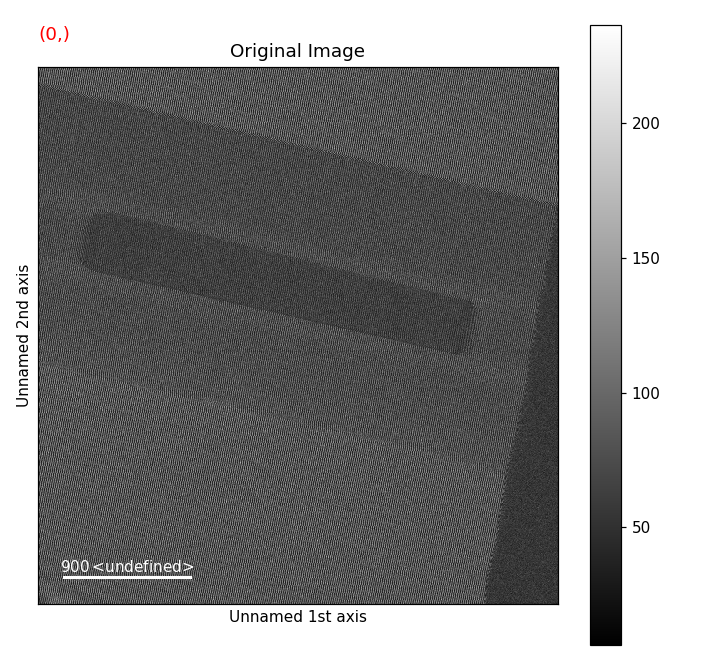

<IPython.core.display.Javascript object>


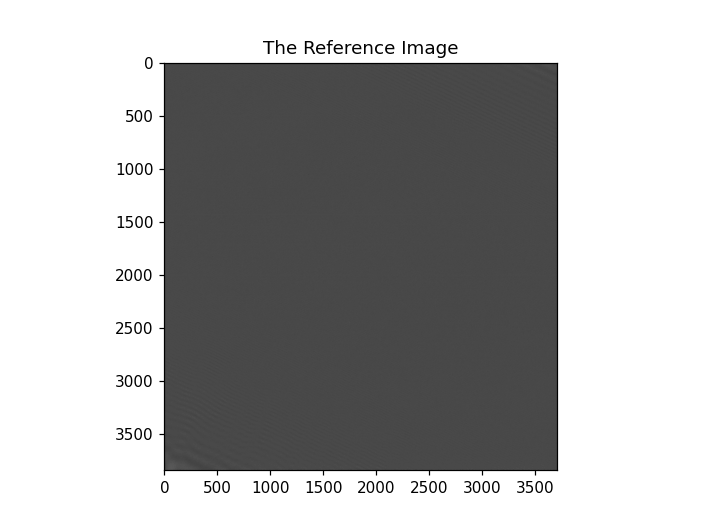

Text(0.5, 1.0, 'The Reference Image')

In [39]:
image_stack_original = hs.signals.Signal2D(image_original,stack=True)
image_stack_original.plot(navigator='slider', 
                          vmax=float(np.max(clipped(image_original))),
                          title="Original Image")
plt.figure()
plt.imshow(image_reference[0], vmax=(np.max(clipped(image_reference))), cmap="gray")
plt.title('The Reference Image')

### Creating an Aperture
For the purpose of reconstruction, it is necessary to create an Aperture. The requirements to create an aperture are the position of the sideband and the size of the sideband. 

#### Estimation of the sideband's position and size
In the liberTEM-Holo package, there are two functions to estimate the position and the size of the sideband. Here the first reference image is used to defined the sideband's position and size.

In [42]:
#estimate the position of the sidebands
sb_position = estimate_sideband_position(image_reference[0],holo_sampling=(1,1))
#estimate the size of the sidebands
sb_size= estimate_sideband_size(sb_position,
                                image_reference[0].shape,
                                sb_size_ratio=0.5)

#### Creating aperture and slice_fft
After the sideband's size is estimated, the aperture is created with get_aperture function. The slice_fft is needed later for the reconstruct_frame function

In [43]:
#Before using the get_aperture or get_aperture_gauss function, the size of the output need to be defined 
out_shape = (1024,1024)

#Create an Aperture and an array for slice_fft
aperture = disk_aperture(out_shape=out_shape, radius=sb_size)
slice_fft = get_slice_fft(out_shape=out_shape, sig_shape=image_reference[0].shape)

### Creating Line Mask with Line Filter
The line mask is required to remove the fresnel fringes. The line mask will be combined later on with aperture.

In [44]:
line_mask = line_filter(image_original[0].shape,
                        sidebandpos=sb_position,
                        width=50,
                        length=580,
                        slice_fft=slice_fft)

# Combine the aperture with the line mask
aperture_mask = aperture*line_mask

#### Filtering the aperture
To get a better result, it is recommended to filter the aperture. The function window_filter have some different windows type, which are listed below:
- boxcar
- triang
- blackman
- hamming
- hann
- bartlett
- flattop
- parzen
- bohman
- blackmanharris
- nuttall
- barthann
- kaiser (needs beta)
- gaussian (needs standard deviation)
- general_gaussian (needs power, width)
- slepian (needs width) - dpss (needs normalized half-bandwidth)
- chebwin (needs attenuation)
- exponential (needs decay scale)
- tukey (needs taper fraction)

Some window types need an extra value to be written in the window type.

<IPython.core.display.Javascript object>


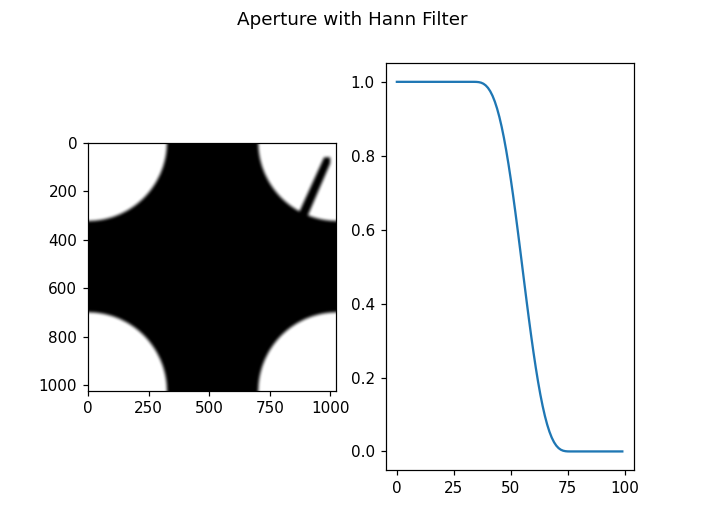

In [45]:
# Hann Filter
aperture_mask_filtered = window_filter(aperture_mask, 'hann', 35) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Aperture with Hann Filter')
ax1.imshow(aperture_mask_filtered, cmap="gray")
ax2.plot(aperture_mask_filtered[200,200:300])

### Reconstruction
The reconstruction is done by using the reconstruct_frame function. Each of the original image and reference image are reconstructed.

In [50]:
# Reconstruction
# Preparing an array to store the reconstructed images
image_stack_unregistered = np.zeros((len(image_original), out_shape[0], out_shape[1]), dtype=complex)

for i in range(number_of_images):
    # Reconstruction of original image
    wav_original = reconstruct_frame(image_original[i], 
                                     sb_pos=sb_position, 
                                     slice_fft=slice_fft, 
                                     aperture=aperture_mask_filtered)                                
    # Reconstruction of reference image
    wav_reference = reconstruct_frame(image_reference[i],
                                     sb_pos=sb_position, 
                                     slice_fft=slice_fft, 
                                     aperture=aperture_mask_filtered)
    # Correction with the reference image
    image_stack_unregistered[i,:,:] = wav_original/wav_reference
                                 

<IPython.core.display.Javascript object>


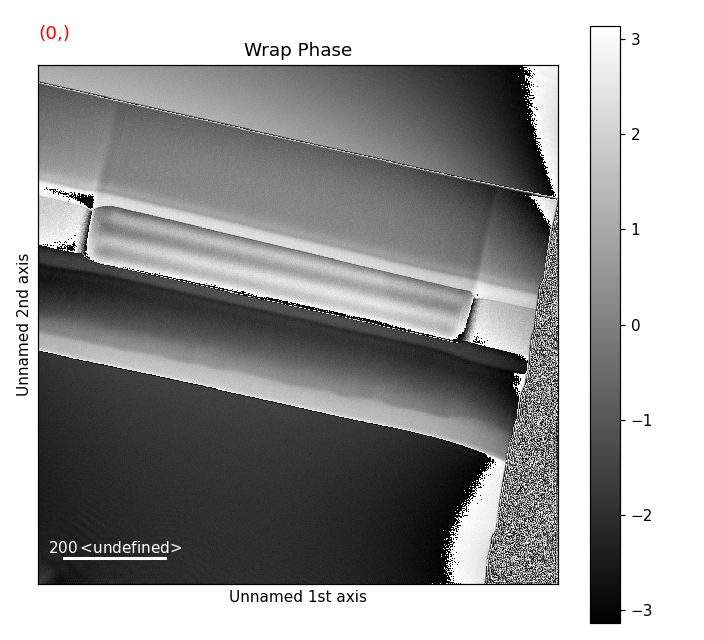

In [51]:
image_stack_unregistered_view = hs.signals.Signal2D(np.angle(image_stack_unregistered),stack=True)
image_stack_unregistered_view.plot(navigator='slider', 
                              title="Wrap Phase")

### Stacking, Registering and Averaging
Before the averaging, the reconstructed images are shifted and registered. The registering and averaging are done by stackregistered function. 


<IPython.core.display.Javascript object>


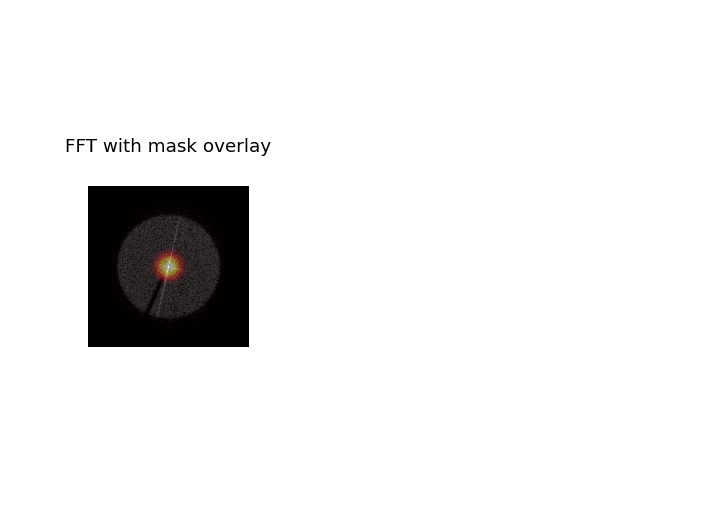

In [55]:
#### Preparation before registering process
#normalizing the value for faster computation
image_stack_unregistered = image_stack_unregistered[:,:,:]/float(2**16)

#instantiate imstack object and get all FFTs
image_stack_object = stackregistration.imstack(image_stack_unregistered)
image_stack_object.getFFTs()


# Creating fourier mask 
# This mask is needed for finding the cross correlation
# There are 6 types of mask available :
# bandpass", "lowpass", "hann", "hamming", "blackman", "gaussian"

image_stack_object.makeFourierMask(mask="lowpass",n=4)
image_stack_object.show_Fourier_mask()

#### Calculating the image shift
There are 3 methods to find the correlation between the images (Cross Correlation, Mutual Correlation, and Phase Correlation ) and 3 methods to find the maximum value in the correlations (Pixel, Gaussian Fit, and Center of Mass).
To find the best method, it is recommended to display the result of the registered images, and see whether there are still movement between the images.

In [58]:
# calculate image shifts with brightest pixel method
t0 = time()
image_stack_object.findImageShifts(correlationType="pc", findMaxima="pixel", verbose=False)
t=time()-t0
print("Performed {} correlations in {} minutes {} seconds".format(int(image_stack_object.nz*(image_stack_object.nz-1)/2),int(t/60),t%60))

Performed 435 correlations in 0 minutes 17.083207368850708 seconds


<IPython.core.display.Javascript object>


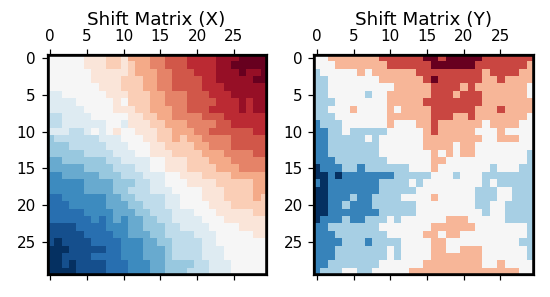

<IPython.core.display.Javascript object>


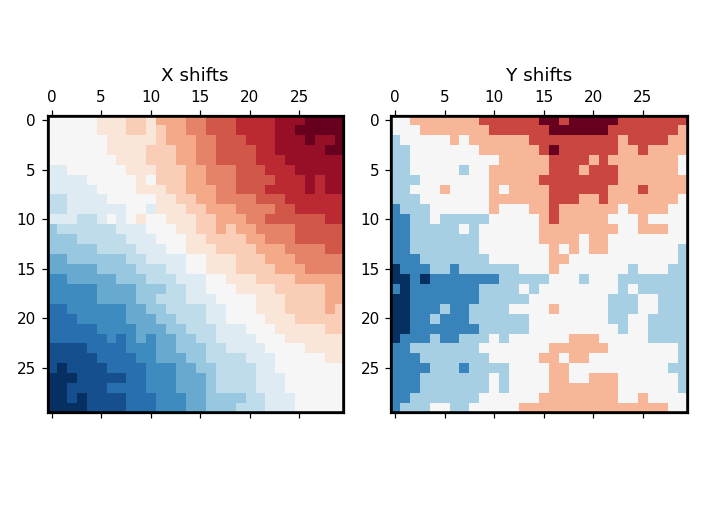

In [59]:
# Display the shift matrix and fix the outliers
# Show Xij and Yij matrices
image_stack_object.show_Rij()
# Identify outliers by enforcing transitivity
image_stack_object.get_outliers(threshold=5,maxpaths=3)

image_stack_object.make_corrected_Rij()
image_stack_object.show_Rij_c()

#### Registering and Averaging
The registering and averaging are done in one function. The quality of the shifting and registering process need to be observed, so that the best correlation type and method to finding the maximum value can be defined correctly. If the shifting and registering are done correctly, the averaged image could be unwrap to finalize the process.

In [60]:
# Registration and Averaging
image_stack_object.get_averaged_image()

<IPython.core.display.Javascript object>


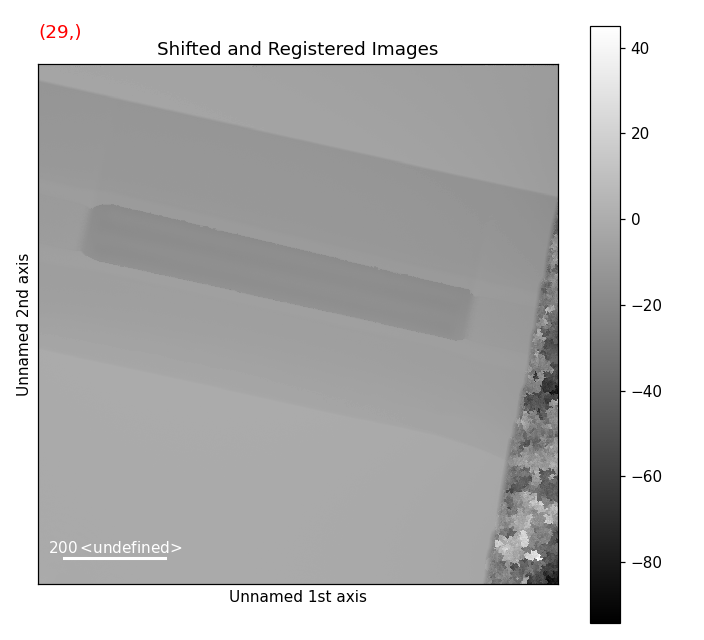

In [61]:
# Display the shifted and registered images
image_stack_registered_view = hs.signals.Signal2D(unwrap_phase(np.angle(image_stack_object.stack_registered)),stack=True)
image_stack_registered_view.plot(navigator='slider', title="Shifted and Registered Images")

### Unwrapping
The unwrapping is done by using skimage.restoration.unwrap_phase. For a better display, a mask is created to mask out the noise in the bottom left area. The minimum value and maximal value for vmin and vmax is calculated with numpy min and numpy max of the image without the noisy area.

<IPython.core.display.Javascript object>


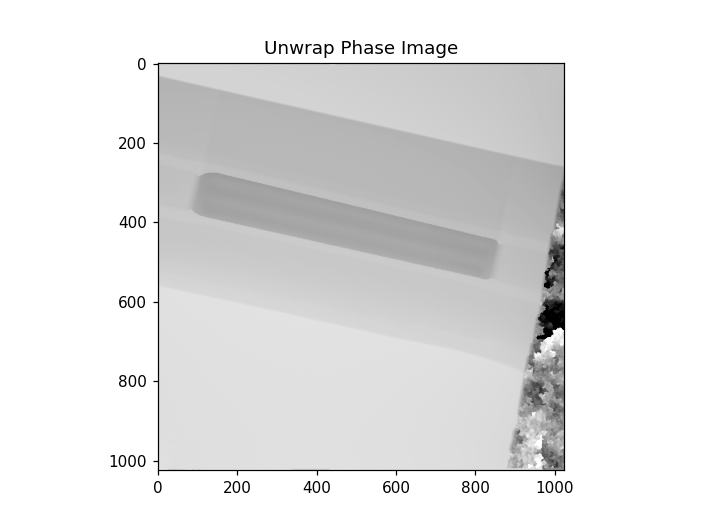

Text(0.5, 1.0, 'Unwrap Phase Image')

In [62]:
#unwrapping
unwrap_phase_image = unwrap_phase(np.angle(image_stack_object.average_image))

#creating mask with skimage draw_polygon
from skimage.draw import polygon
r = np.array([270, 1023 , 1023])
c = np.array([1023, 1023, 875])
rr, cc = polygon(r, c)
mask_roi = np.ones((1024,1024))
mask_roi[rr, cc] = 0

#calculating vmin, vmax
vmin = np.min(unwrap_phase_image*mask_roi)
vmax = np.max(unwrap_phase_image*mask_roi)

plt.figure()
plt.imshow(unwrap_phase_image, vmin=vmin, vmax=vmax, cmap="gray")
plt.title('Unwrap Phase Image')


### Advanced plotting
Plot the curl and the cosine contour with empyre package.
The documentation of the empyre could be find in the link below:
https://empyre.iffgit.fz-juelich.de/empyre/vis.html

<IPython.core.display.Javascript object>


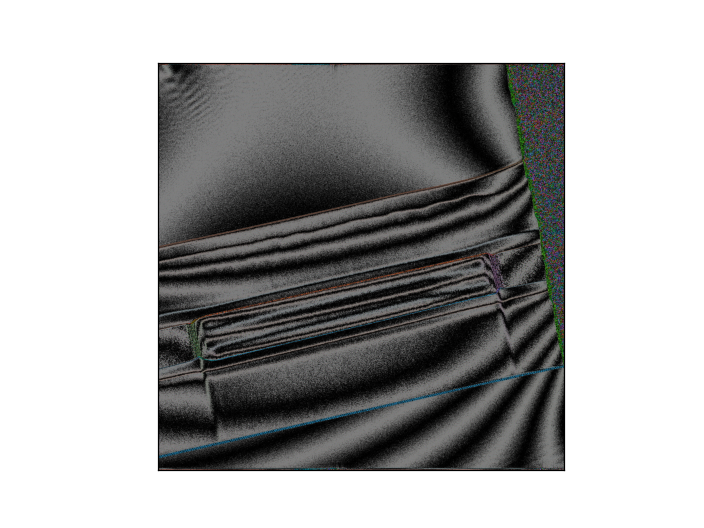

In [63]:
# Represent the unwrap phase image with the 'field' class
phase_field= emp.fields.Field(data=unwrap_phase_image, scale=1, vector=False)
cmap = emp.vis.colors.cmaps.cyclic_cubehelix
plt.figure()
#Display the curl
emp.vis.colorvec(phase_field.curl().clip(sigma=1), cmap=cmap)
#Display the cosine contours
emp.vis.cosine_contours(phase_field, gain = 5)